# Streaming Data Management and Time Series Analysis
**Master's Degree in Data Science (A.Y. 2023/2024)**<br/>
**University of Milano - Bicocca**<br/>

Luca Porcelli

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installing packages and loading libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from tqdm import tqdm
import warnings
from math import sqrt
import statsmodels.api as sm
import itertools
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import random
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from itertools import product

random.seed(42)
# Ignore warnings
warnings.filterwarnings('ignore')

# Data

In [ ]:
path = "/content/drive/MyDrive/Time Series Analysis/train.csv"
df = pd.read_csv(path)

In [ ]:
df

,date,weekday,ave_days
0,2007-01-04,Thursday,0.179487
1,2007-01-05,Friday,0.500000
2,2007-01-06,Saturday,NaN
3,2007-01-07,Sunday,NaN
4,2007-01-08,Monday,3.521739
...,...,...,...
3004,2015-03-27,Friday,38.580756
3005,2015-03-28,Saturday,1.040000
3006,2015-03-29,Sunday,42.000000
3007,2015-03-30,Monday,63.477124


## Data Exportation

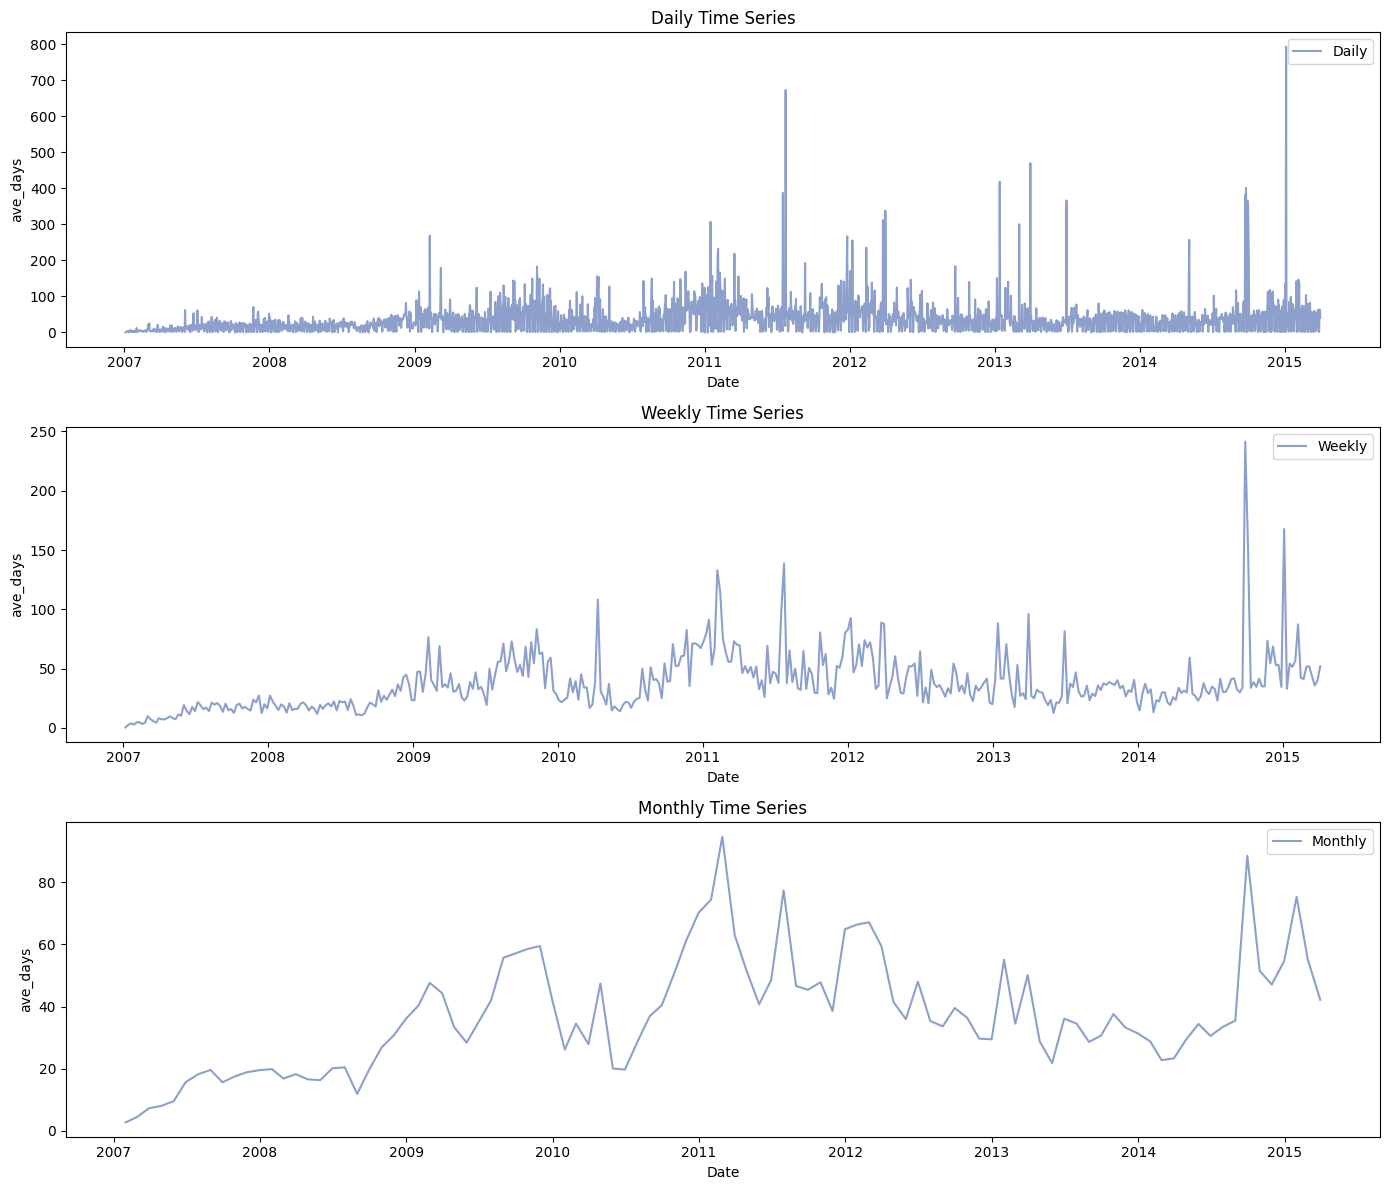

In [ ]:
# Convert the 'date' column to datetime format and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Resample into daily, weekly, and monthly data
daily_data = df['ave_days'].resample('D').mean()
weekly_data = df['ave_days'].resample('W').mean()
monthly_data = df['ave_days'].resample('M').mean()

# Set color palette
palette = sns.color_palette("Set2")

# Create the plots
plt.figure(figsize=(14, 12))

# Daily plot
plt.subplot(3, 1, 1)
sns.lineplot(data=daily_data, label='Daily', color=palette[2])
plt.title('Daily Time Series')
plt.xlabel('Date')
plt.ylabel('ave_days')
plt.legend()

# Weekly plot
plt.subplot(3, 1, 2)
sns.lineplot(data=weekly_data, label='Weekly', color=palette[2])
plt.title('Weekly Time Series')
plt.xlabel('Date')
plt.ylabel('ave_days')
plt.legend()

# Monthly plot
plt.subplot(3, 1, 3)
sns.lineplot(data=monthly_data, label='Monthly', color=palette[2])
plt.title('Monthly Time Series')
plt.xlabel('Date')
plt.ylabel('ave_days')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Reset index to revert 'date' to a regular column
df = df.reset_index()

# Pre-Processing

## Missing values

Checking null values

In [ ]:
df.isnull().sum()

date          0
weekday       0
ave_days    202
dtype: int64

In [ ]:
# Select rows where 'ave_days' column is null
null_values = df[df['ave_days'].isnull()]

# Count null values by weekday
null_counts_by_weekday = null_values['weekday'].value_counts()

In [ ]:
null_counts_by_weekday

weekday
Sunday      167
Monday       20
Saturday      6
Friday        4
Thursday      4
Tuesday       1
Name: count, dtype: int64

Quantity as a percentage null values

In [ ]:
# Calculate the overall percentage of null values in 'ave_days'
null_percentage_general = (df['ave_days'].isnull().sum() / len(df)) * 100

# Calculate the percentage of null values for each weekday
null_percentage_by_weekday = (null_values['weekday'].value_counts() / df['weekday'].value_counts()) * 100

print(f'Overall percentage of null values: {null_percentage_general:.2f}%')
for weekday, percentage in null_percentage_by_weekday.items():
    print(f'{weekday}: {percentage:.2f}%')

Overall percentage of null values: 6.71%
Friday: 0.93%
Monday: 4.65%
Saturday: 1.40%
Sunday: 38.84%
Thursday: 0.93%
Tuesday: 0.23%
Wednesday: nan%


Imputation of null values with the average for each day of the week

In [ ]:
#df['ave_days'] = df['ave_days'].fillna(0)

In [ ]:
# Imputation of null values with the mean of the respective weekday
mean_by_weekday = df.groupby('weekday')['ave_days'].mean()
df['ave_days'] = df.apply(lambda row: mean_by_weekday[row['weekday']] if pd.isnull(row['ave_days']) else row['ave_days'], axis=1)

## Outliers

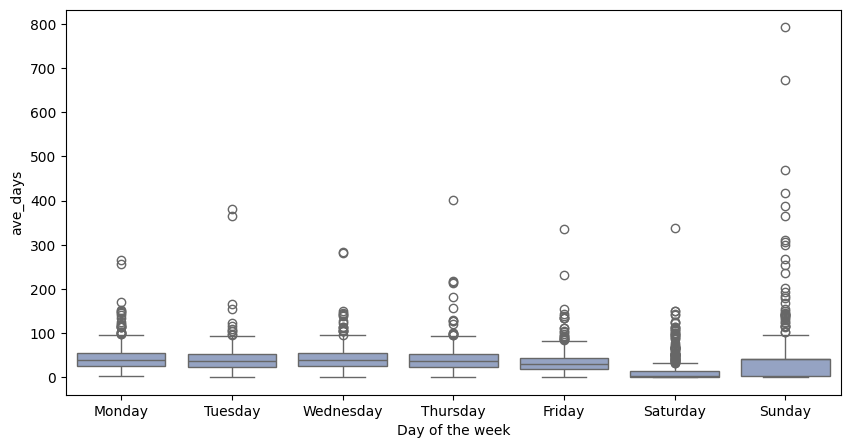

In [ ]:
# Convert the 'date' column to datetime format and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Daily resampling, calculating the mean
daily_data = df['ave_days'].resample('D').mean()

# Create a DataFrame with daily data and the name of the weekday
daily_data_df = pd.DataFrame({'ave_days': daily_data, 'weekday_name': daily_data.index.day_name()})

# Set a color palette
palette = sns.color_palette("Set2")
color_to_use = palette[2]  # Use the same color as in previous plots

# Define the order of weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a boxplot for the daily time series
plt.figure(figsize=(10, 5))
sns.boxplot(x='weekday_name', y='ave_days', data=daily_data_df, color=color_to_use, order=weekday_order)
plt.xlabel('Day of the week')
plt.ylabel('ave_days')
plt.show()
df = df.reset_index()

Maximum value of the upper whisker limit: 96.0


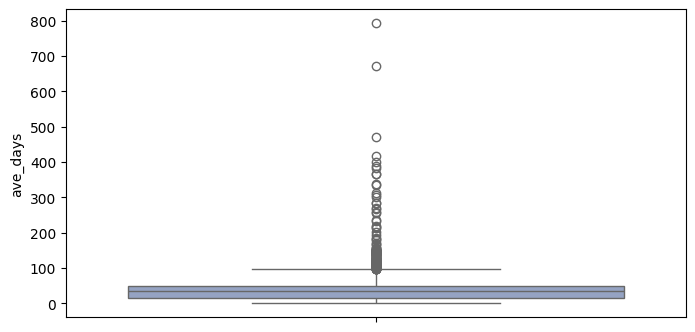

In [ ]:
# Convert the 'date' column to datetime format and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Daily resampling, calculating the mean
daily_data = df['ave_days'].resample('D').mean()

# Create a boxplot for the daily time series
plt.figure(figsize=(8, 4))
sns.boxplot(y=daily_data, color=color_to_use)
plt.ylabel('ave_days')

# Find and print the maximum value represented by the upper whisker limit
whiskers = plt.gca().lines[2:4]  # Lines 2 and 3 represent the whiskers
max_whisker_value = max(whiskers[1].get_ydata())  # Get the second whisker (upper limit)
print("Maximum value of the upper whisker limit:", max_whisker_value)

plt.show()
df = df.reset_index()

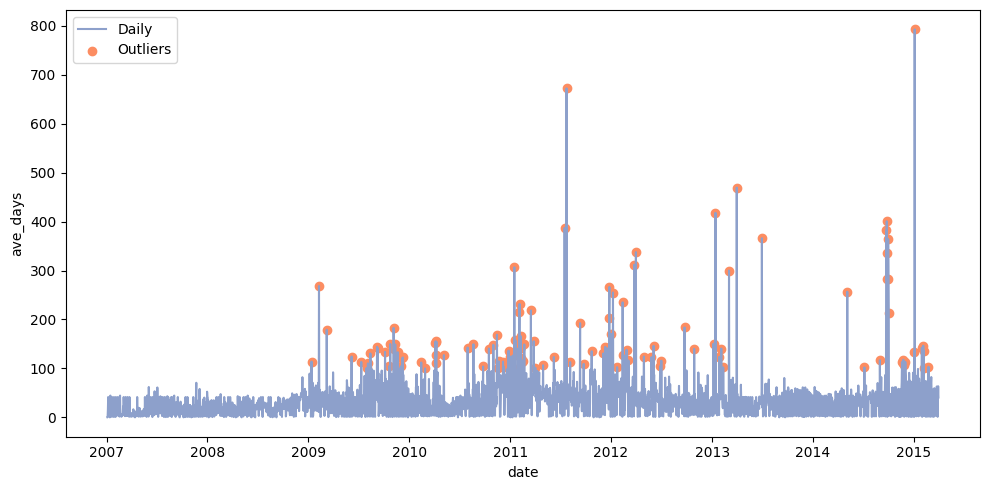

In [ ]:
df.set_index('date', inplace=True)

# Find the outliers
outliers = df[df['ave_days'] > 100]

# Daily resampling
daily_data = df['ave_days'].resample('D').mean()

# Set a color palette
palette = sns.color_palette("Set2")

# Create the plot
plt.figure(figsize=(10, 5))

# Daily plot
sns.lineplot(data=daily_data, label='Daily', color=palette[2])
plt.scatter(outliers.index, outliers['ave_days'], color=palette[1], label='Outliers')
plt.ylabel('ave_days')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
df = df.reset_index()

In [ ]:
# Count outliers
(df['ave_days'] > 100).sum()

120

In [ ]:
df['ave_days'] = df['ave_days'].apply(lambda x: min(x, 100))

## Stationary Analysis

In [ ]:
# Create a time series from the 'ave_days' column
days = pd.Series(df['ave_days'].values, index=df['date'])

### Test ADF

In [ ]:
adf_result = adfuller(days)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])

ADF Statistic: -3.646880800205368
p-value: 0.00492548830873978
Critical Values: {'1%': -3.432545551806462, '5%': -2.8625100519404665, '10%': -2.5672863845358074}


### Test KPSS

In [ ]:
kpss_result = kpss(days)
print('\nKPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])
print('Critical Values:', kpss_result[3])


KPSS Statistic: 2.9274896690307655
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


### Acf e Pacf

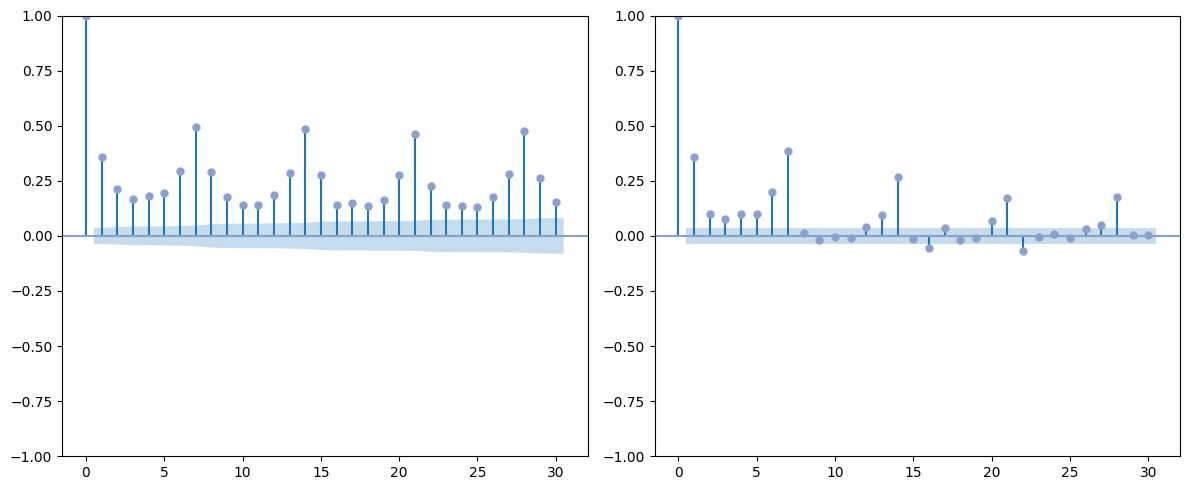

In [ ]:
# Define the color palette
palette = sns.color_palette("Set2")

# Create a figure with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot ACF
plot_acf(days, lags=30, color=palette[2], ax=axes[0])  # Use the second color from the palette
axes[0].set_title('')

# Plot PACF
plot_pacf(days, lags=30, color=palette[2], ax=axes[1])  # Use the second color from the palette
axes[1].set_title('')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

## Transformations

### Log

In [ ]:
log_transform = log(days + 1)

In [ ]:
df.set_index('date', inplace=True)
df['ave_days'] = log_transform
df.reset_index(inplace=True)
# Save DataFrame to CSV file
df.to_csv('/content/drive/MyDrive/Time Series Analysis/Clean_train.csv', index=False)

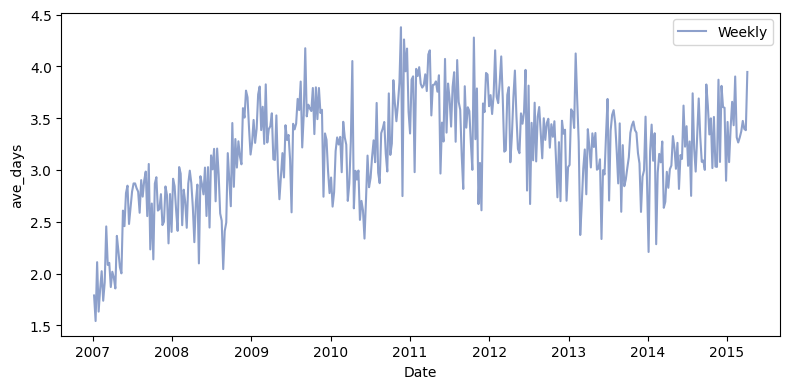

In [ ]:
# Set a color palette
palette = sns.color_palette("Set2")

# Create the plots
plt.figure(figsize=(8, 4))

# Weekly resampling and calculation of mean
serie_settim = log_transform.resample('W').mean()

# Weekly plot
sns.lineplot(data=serie_settim, label='Weekly', color=palette[2])
plt.xlabel('Date')
plt.ylabel('ave_days')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Reset index
df = df.reset_index()

In [ ]:
adf_result = adfuller(log_transform)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])

kpss_result = kpss(log_transform)
print('\nKPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])
print('Critical Values:', kpss_result[3])

ADF Statistic: -4.549206738911887
p-value: 0.0001600726068465428
Critical Values: {'1%': -3.432545551806462, '5%': -2.8625100519404665, '10%': -2.5672863845358074}

KPSS Statistic: 8.138162326400922
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


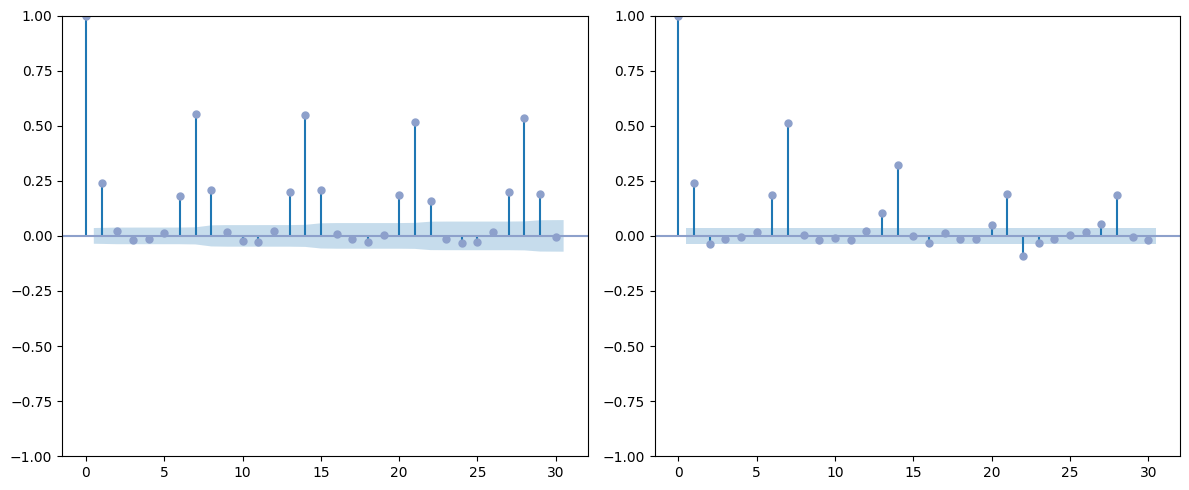

In [ ]:
# Define the color palette
palette = sns.color_palette("Set2")

# Create a figure with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot ACF
plot_acf(log_transform, lags=30, color=palette[2], ax=axes[0])  # Use the second color from the palette
axes[0].set_title('')

# Plot PACF
plot_pacf(log_transform, lags=30, color=palette[2], ax=axes[1])  # Use the second color from the palette
axes[1].set_title('')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

# Models

In [ ]:
train = log_transform['2007-01-04':'2014-08-01']
test = log_transform['2014-08-02':]

## SARIMA

In [ ]:
'''# List of parameters to test
p = d = q = range(0, 3)
P = D = Q = range(0, 3)
s = [7]  # Seasonal periodicity

# Generate all possible parameter combinations
parameters = [(x[0], x[1], x[2], y[0], y[1], y[2], z) for x in list(np.array(np.meshgrid(p, d, q)).T.reshape(-1, 3)) for y in list(np.array(np.meshgrid(P, D, Q)).T.reshape(-1, 3)) for z in s]

# Variables to store the best parameters and lowest MAE
best_params = None
lowest_mae = float('inf')

# Counter to track the current iteration
iteration = 0
total_iterations = len(parameters)

# Grid search with tqdm for visual feedback
for param in tqdm(parameters, desc='Grid search progress'):
    try:
        model = SARIMAX(train, order=(param[0], param[1], param[2]), seasonal_order=(param[3], param[4], param[5], param[6]), enforce_stationarity=False, enforce_invertibility=False)
        fit_model = model.fit(disp=False)

        forecast_values = fit_model.predict(start=test.index[0], end=test.index[-1], dynamic=False)
        mae = mean_absolute_error((np.exp(forecast_values) - 1), (np.exp(test) - 1))

        if mae < lowest_mae:
            lowest_mae = mae
            best_params = param

    except Exception as e:
        continue

# Print the best parameters and lowest MAE
print('Best Parameters:', best_params)
print('Lowest MAE:', lowest_mae)

# Train the model with the best parameters
best_model = SARIMAX(train, order=(best_params[0], best_params[1], best_params[2]), seasonal_order=(best_params[3], best_params[4], best_params[5], best_params[6]), enforce_stationarity=False, enforce_invertibility=False)
best_fit = best_model.fit(disp=False)

# Forecast on the test set
best_forecast_values = best_fit.predict(start=test.index[0], end=test.index[-1], dynamic=False)

# Calculate performance metrics on the test set
mae_test = mean_absolute_error((np.exp(best_forecast_values) - 1), (np.exp(test) - 1))

# Print performance
print('MAE:', mae_test)'''

Grid search progress: 100%|██████████| 729/729 [1:34:25<00:00,  7.77s/it]


Best Parameters: (1, 1, 0, 1, 1, 2, 7)
Lowest MAE: 16.97405496294562
MAE: 16.97405496294562


In [ ]:
# Define SARIMAX model with specified orders and options
model = SARIMAX(train,                        # Training data for model fitting
                order=(1, 1, 0),              # (p, d, q): ARIMA order parameters
                seasonal_order=(1, 1, 2, 7),  # (P, D, Q, S): Seasonal order parameters
                enforce_stationarity=False,   # Do not enforce stationarity
                enforce_invertibility=False)  # Do not enforce invertibility

# Fit the SARIMAX model to the training data
fit = model.fit()

# Get forecasts on the test set
predictions = fit.predict(start=test.index[0], end=test.index[-1], dynamic=False)

# Calculate performance metrics on the test set
mae_test = mean_absolute_error((np.exp(predictions) - 1), (np.exp(test) - 1))     # Mean Absolute Error (MAE)

# Print the performance
print('MAE:', mae_test)

MAE: 16.97405496294562


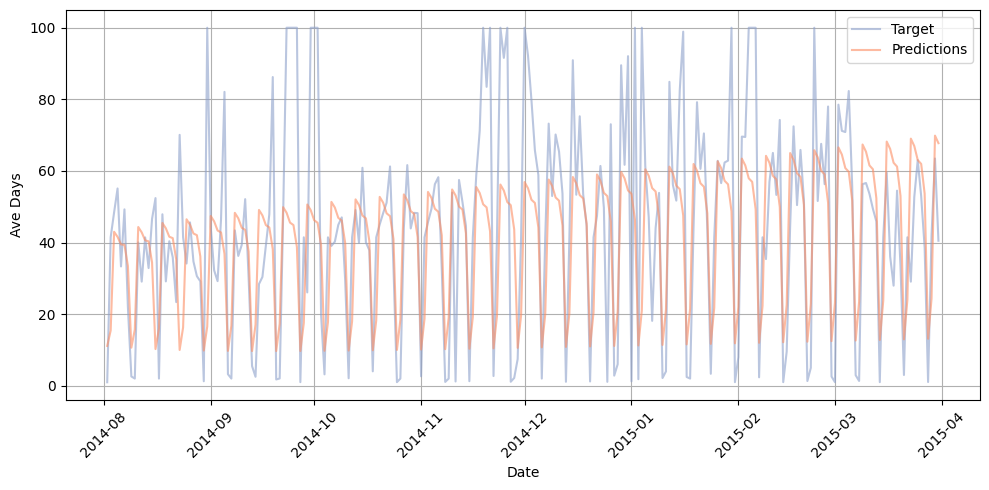

In [ ]:
test.index = pd.to_datetime(test.index)

# Set color palette
palette = sns.color_palette("Set2")

# Convert y_test and predictions to Series for plotting
y_test_series = pd.Series(np.exp(test.values) - 1, index=test.index)
predictions_series = pd.Series(np.exp(predictions.values) - 1, index=test.index)

plt.figure(figsize=(10, 5))

# Plot actual values
plt.plot(y_test_series.index, y_test_series, label='Target', color=palette[2], alpha=0.6)

# Plot predictions
plt.plot(predictions_series.index, predictions_series, label='Predictions', color=palette[1], alpha=0.6)

plt.xlabel('Date')
plt.ylabel('Ave Days')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

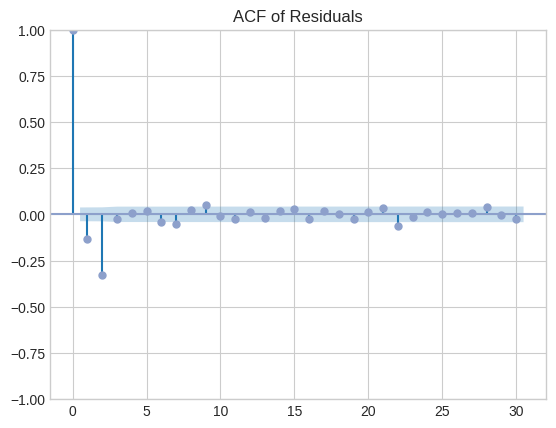

In [ ]:
residuals = fit.resid

# Define the color palette
palette = sns.color_palette("Set2")

plot_acf(residuals, lags=30, color=palette[2])
plt.title('ACF of Residuals')
plt.show()

### Forecast

In [ ]:
# Define SARIMAX model with specified orders and options
model = SARIMAX(log_transform,                  # Time series data to fit
                order=(1, 1, 0),              # (p, d, q): ARIMA order parameters
                seasonal_order=(1, 1, 2, 7),  # (P, D, Q, S): Seasonal order parameters
                enforce_stationarity=False,     # Do not enforce stationarity
                enforce_invertibility=False)    # Do not enforce invertibility

# Fit the SARIMAX model to the data
fit = model.fit()

# Specify start and end dates for forecasting
start_date = '2015-04-01'
end_date = '2015-11-07'

# Create a date index for the forecast period with daily frequency
forecast_index_sarima = pd.date_range(start=start_date, end=end_date, freq='D')

# Generate forecasts and confidence intervals
forecast_values_sarima = fit.get_forecast(steps=len(forecast_index_sarima))
forecast_mean_sarima = forecast_values_sarima.predicted_mean  # Extract predicted mean values
forecast_ci_sarima = forecast_values_sarima.conf_int()        # Extract confidence intervals

# Create a DataFrame with the SARIMA forecasts
forecast_df_sarima = pd.DataFrame(data={'SARIMA': np.exp(forecast_mean_sarima) - 1}, index=forecast_index_sarima)

# Display the DataFrame with forecasts
print(forecast_df_sarima)

               SARIMA
2015-04-01  51.687207
2015-04-02  42.750578
2015-04-03  42.343617
2015-04-04   2.184731
2015-04-05  16.432045
...               ...
2015-11-03  40.833627
2015-11-04  43.590629
2015-11-05  35.885376
2015-11-06  37.738163
2015-11-07   2.296196

[221 rows x 1 columns]


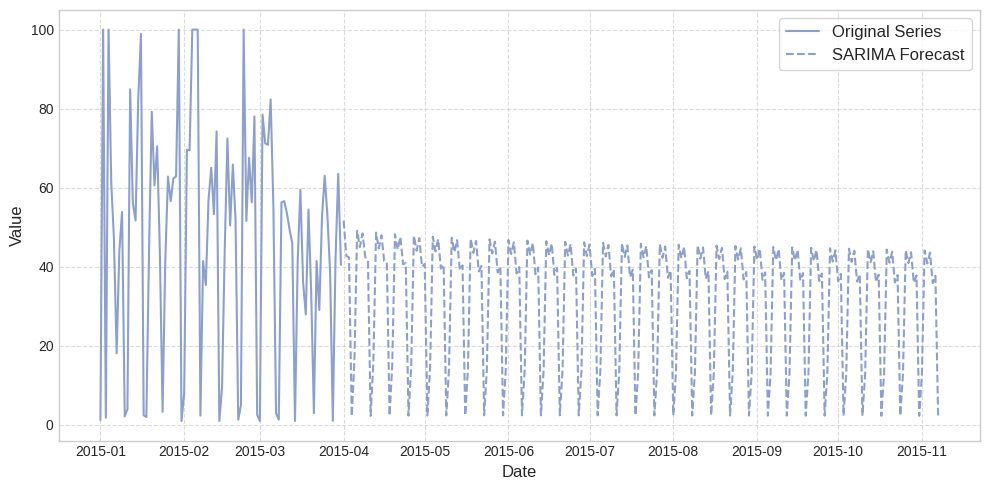

In [ ]:
# Extract the last 3 months of the original series
last_3_months_values = np.exp(log_transform[-90:]) - 1 # Values of the last 90 days

# Create a combined dataframe
combined_df = pd.concat([last_3_months_values, forecast_df_sarima], axis=1)
combined_df.columns = ['Original Series', 'SARIMA Forecast']  # Rename columns for clarity

# Ensure the index is a DatetimeIndex
combined_df.index = pd.to_datetime(combined_df.index)

# Set color palette for visual consistency
palette = sns.color_palette("Set2")

# Set plot style for better readability
plt.style.use('seaborn-whitegrid')

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(combined_df.index, combined_df['Original Series'], label='Original Series', color=palette[2])
plt.plot(combined_df.index, combined_df['SARIMA Forecast'], label='SARIMA Forecast', color=palette[2], linestyle='dashed')

# Set labels for x and y axes
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Add a legend with frame for clarity
plt.legend(fontsize=12, loc='best', frameon=True)

# Add a light grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

## UCM

In [ ]:
'''# Define options for each component
levels = ["irregular", "fixed intercept", "deterministic constant", "local level", "random walk",
          "fixed slope", "deterministic trend", "local linear deterministic trend", "random walk with drift",
          "local linear trend", "smooth trend", "random trend", False]
trends = [True, False]
seasonals = [7]
stochastic_levels = [True, False]
stochastic_trends = [True, False]
stochastic_seasonals = [True, False]

# Generate all combinations of the components
component_combinations = list(itertools.product(levels, trends, seasonals, stochastic_levels, stochastic_trends, stochastic_seasonals))

# Initialize a list for results
results = []

# Iterate through all combinations and evaluate the model
for config in tqdm(component_combinations, desc="Progress"):
    # Build and fit the model
    model = sm.tsa.UnobservedComponents(
        train,
        level=config[0],
        trend=config[1],
        seasonal=config[2],
        stochastic_level=config[3],
        stochastic_trend=config[4],
        stochastic_seasonal=config[5]
    )
    result = model.fit()

    # Forecast on the test data
    forecast = result.get_forecast(steps=len(test))
    predictions = forecast.predicted_mean

    # Calculate MAE
    mae = np.abs((np.exp(predictions) - 1) - (np.exp(test) - 1)).mean()

    # Store the results
    results.append({'config': config, 'mae': mae, 'summary': result.summary()})

# Sort results by MAE
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='mae')

# Print the best model
best_model = results_df.iloc[0]
print("Best model:")
print(best_model['config'])
print(f"MAE: {best_model['mae']}")'''

Progress: 100%|██████████| 208/208 [02:28<00:00,  1.40it/s]

Best model:
('smooth trend', True, 7, False, False, False)
MAE: 16.942683585307158


In [ ]:
model = sm.tsa.UnobservedComponents(
    train,
    level="smooth trend",
    trend=True,
    seasonal=7,
    stochastic_level=False,
    stochastic_trend=False,
    stochastic_seasonal=False
)
result = model.fit()

# Forecast on the test data
forecast = result.get_forecast(steps=len(test))
predictions = forecast.predicted_mean

# Calculate MAE
mae = mean_absolute_error((np.exp(predictions) - 1), (np.exp(test) - 1))
print(mae)

16.942683585307158


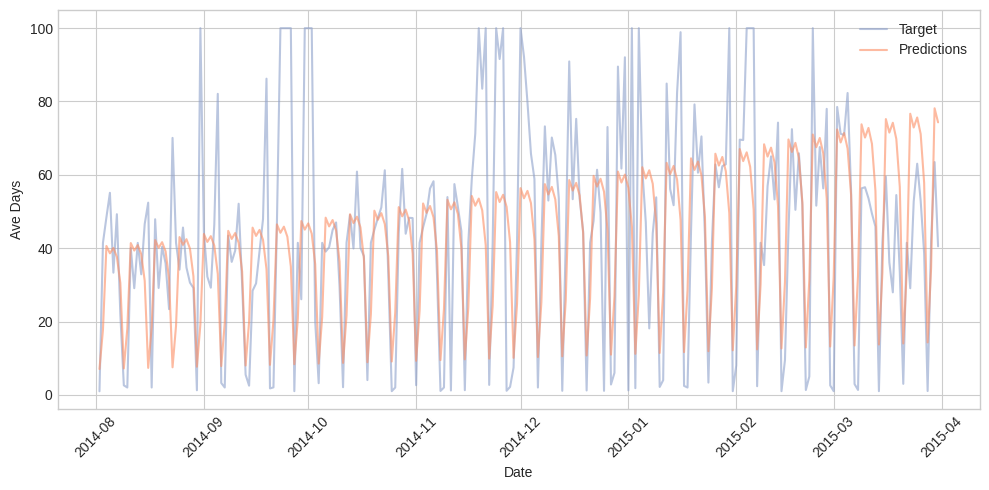

In [ ]:
test.index = pd.to_datetime(test.index)

# Set color palette
palette = sns.color_palette("Set2")

# Convert y_test and predictions to Series for plotting
y_test_series = pd.Series(np.exp(test.values) - 1, index=test.index)
predictions_series = pd.Series(np.exp(predictions.values) - 1, index=test.index)

plt.figure(figsize=(10, 5))

# Plot actual values
plt.plot(y_test_series.index, y_test_series, label='Target', color=palette[2], alpha=0.6)

# Plot predictions
plt.plot(predictions_series.index, predictions_series, label='Predictions', color=palette[1], alpha=0.6)

plt.xlabel('Date')
plt.ylabel('Ave Days')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

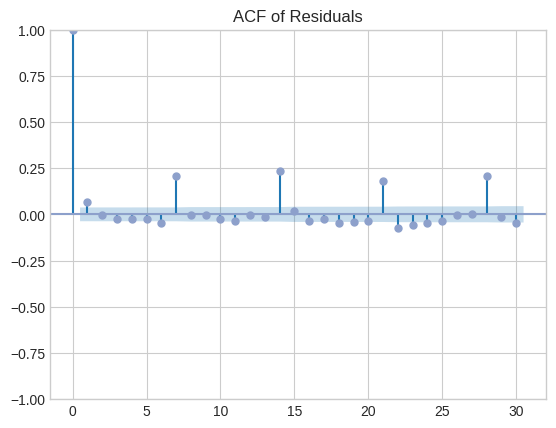

In [ ]:
residuals = result.resid

# Define the color palette
palette = sns.color_palette("Set2")

plot_acf(residuals, lags=30, color=palette[2])
plt.title('ACF of Residuals')
plt.show()

### Forecast

In [ ]:
# Define the UnobservedComponents model with specified components
model = sm.tsa.UnobservedComponents(log_transform,
                                    level='smooth trend',   # Type of trend component
                                    trend=True,                  # Disable deterministic trend
                                    seasonal=7,                   # Seasonal period of 7 days
                                    stochastic_level=False,        # Allow stochastic level
                                    stochastic_trend=False,        # Allow stochastic trend
                                    stochastic_seasonal=False)    # Disable stochastic seasonal component

# Fit the model to the training data
result = model.fit()

# Specify start and end dates for forecasting
start_date = '2015-04-01'
end_date = '2015-11-07'

# Create a date index for the forecasting period
forecast_index = pd.date_range(start=start_date, end=end_date, freq='D')

# Generate forecasts for the specified index
forecast = result.get_forecast(steps=len(forecast_index))

# Extract the predicted mean values
predictions = forecast.predicted_mean

# Create a DataFrame with the forecasts
forecast_df_ucm = pd.DataFrame(data={'UCM': np.exp(predictions) - 1}, index=forecast_index)

# Display the DataFrame with forecasts
print(forecast_df_ucm)

                  UCM
2015-04-01  44.982046
2015-04-02  41.470490
2015-04-03  34.361749
2015-04-04   7.306288
2015-04-05  19.324976
...               ...
2015-11-03  42.491370
2015-11-04  44.275898
2015-11-05  40.818270
2015-11-06  33.818697
2015-11-07   7.178729

[221 rows x 1 columns]


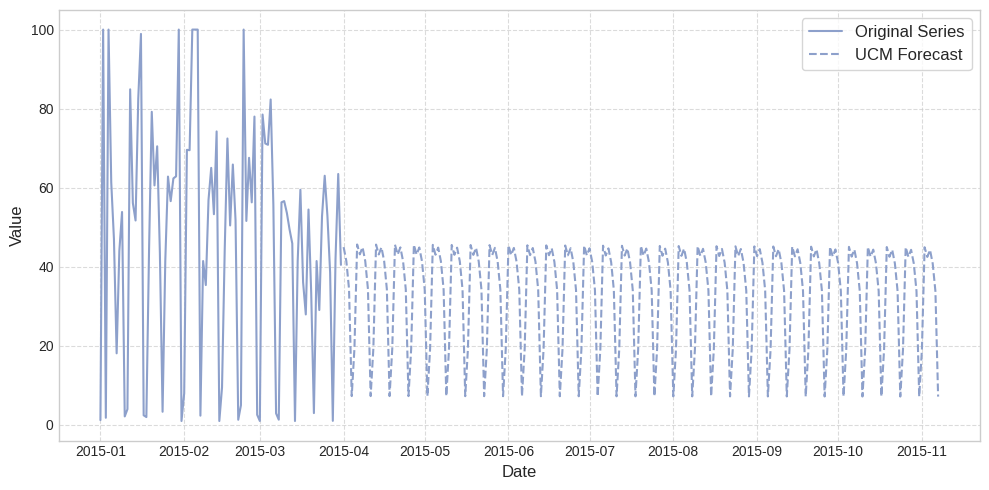

In [ ]:
# Extract the last 3 months of the original series
last_3_months_values = np.exp(log_transform[-90:]) - 1 # Values of the last 90 days

# Create a combined dataframe
combined_df = pd.concat([last_3_months_values, forecast_df_ucm], axis=1)
combined_df.columns = ['Original Series', 'UCM Forecast']  # Rename columns for clarity

# Ensure the index is a DatetimeIndex
combined_df.index = pd.to_datetime(combined_df.index)

# Set color palette for visual consistency
palette = sns.color_palette("Set2")

# Set plot style for better readability
plt.style.use('seaborn-whitegrid')

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(combined_df.index, combined_df['Original Series'], label='Original Series', color=palette[2])
plt.plot(combined_df.index, combined_df['UCM Forecast'], label='UCM Forecast', color=palette[2], linestyle='dashed')

# Set labels for x and y axes
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Add a legend with frame for clarity
plt.legend(fontsize=12, loc='best', frameon=True)

# Add a light grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

## ML

In [ ]:
path = "/content/drive/MyDrive/Time Series Analysis/Clean_train.csv"
df = pd.read_csv(path)

In [ ]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract year, month, and day
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# Copy 'date' column to another dataframe if needed
df_data = df["date"].copy()
# Drop the original 'date' column if no longer needed
#df.drop('date', axis=1, inplace=True)
# Assuming 'df' is your DataFrame and 'date' column is already in datetime format
df.set_index('date', inplace=True)

# Convert 'weekday' column to categorical type
df['weekday'] = df['weekday'].astype('category')
# Convert 'weekday' to numerical representation
df['weekday'] = df['weekday'].cat.codes

### Dataset 1

In [ ]:
train = df.loc[ "2007-01-04": "2014-08-01"]
validation = df.loc["2014-08-02" : ]

#defining input and target variable
x_train = train.loc["2007-01-04": "2014-08-01",["weekday", "year", "month", "day"]]

y_train = train.loc["2007-01-04": "2014-08-01", ['ave_days']]

x_test = validation.loc["2014-08-02" : '2015-03-31',["weekday", "year", "month", "day"]]

y_test = validation.loc["2014-08-02" : '2015-03-31',['ave_days']]

#### XGBRegressor

In [ ]:
'''# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 3, 5, 7],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0.1, 0.2],
    'colsample_bytree': [0.5, 0.7, 0.8],
    'n_estimators': [100, 200, 500],
    'objective': ['reg:squarederror']
}

# Initialize variables to keep track of the best MAE and corresponding parameters
best_mae = float('inf')
best_params = None

# Calculate total number of combinations
total_combinations = len(param_grid['learning_rate']) * len(param_grid['max_depth']) * \
                      len(param_grid['min_child_weight']) * len(param_grid['gamma']) * \
                      len(param_grid['colsample_bytree']) * len(param_grid['n_estimators'])

# Loop over all combinations of parameters with tqdm for progress tracking
for params in tqdm(list(product(*param_grid.values())), total=total_combinations, desc="Grid Search Progress"):
    # Create XGBoost model with current parameters
    xgb_model = XGBRegressor(booster='gbtree',
                             learning_rate=params[0],
                             max_depth=params[1],
                             min_child_weight=params[2],
                             gamma=params[3],
                             colsample_bytree=params[4],
                             n_estimators=params[5],
                             objective='reg:squarederror')

    # Train the model
    xgb_model.fit(x_train, y_train)

    # Make predictions on the test set
    predictions = xgb_model.predict(x_test)

    # Calculate MAE
    mae = mean_absolute_error((np.exp(predictions) - 1), (np.exp(y_test) - 1))

    # Check if current MAE is better than the best found so far
    if mae < best_mae:
        best_mae = mae
        best_params = params

# Print the best parameters and corresponding MAE
print("Best Parameters Found:")
print("learning_rate:", best_params[0])
print("max_depth:", best_params[1])
print("min_child_weight:", best_params[2])
print("gamma:", best_params[3])
print("colsample_bytree:", best_params[4])
print("n_estimators:", best_params[5])
print("Lowest MAE Found:", best_mae)'''

Grid Search Progress: 100%|██████████| 864/864 [01:25<00:00, 10.16it/s]

Best Parameters Found:
learning_rate: 0.2
max_depth: 7
min_child_weight: 3
gamma: 0.1
colsample_bytree: 0.8
n_estimators: 100
Lowest MAE Found: 22.441751675384545


In [ ]:
# Create an XGBoost model with specific hyperparameters
xgb_model = XGBRegressor(booster='gbtree',             # Booster type: gradient boosted trees
                          colsample_bytree=0.8,        # Subsample ratio of columns when constructing each tree
                          learning_rate=0.2,           # Learning rate
                          max_depth=7,                 # Maximum depth of trees
                          min_child_weight=3,          # Minimum sum of instance weight needed in a child
                          n_estimators=100,            # Number of boosted trees (estimators)
                          gamma=0.1,                   # Minimum loss reduction required to make a further partition on a leaf node
                          objective='reg:squarederror' # Objective function: regression with squared error
                          )

# Train the XGBoost model on the training data
xgb_model.fit(x_train, y_train)

# Make predictions on the test set
predictions = xgb_model.predict(x_test)

# Calculate and print the Mean Absolute Error (MAE)
mae_value = mean_absolute_error((np.exp(predictions) - 1), (np.exp(y_test) - 1))  # Calculate MAE in original scale if necessary
print("MAE value is:", mae_value)

MAE value is: 22.441751675384545


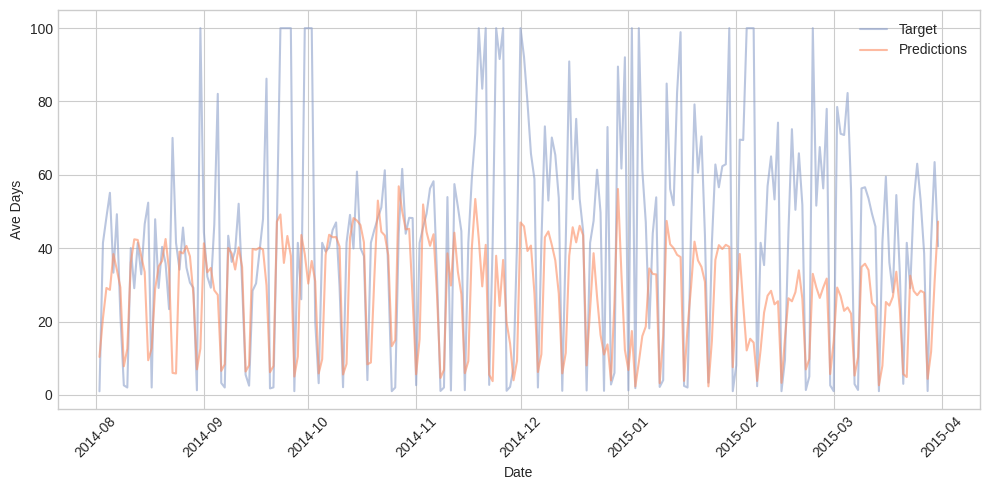

In [ ]:
# Set color palette
palette = sns.color_palette("Set2")

# Convert y_test and predictions to Series for plotting
y_test_series = pd.Series(np.exp(y_test['ave_days'].values) - 1, index=y_test.index)
predictions_series = pd.Series(np.exp(predictions) - 1, index=y_test.index)

plt.figure(figsize=(10, 5))

# Plot actual values
plt.plot(y_test_series.index, y_test_series, label='Target', color=palette[2], alpha=0.6)

# Plot predictions
plt.plot(predictions_series.index, predictions_series, label='Predictions', color=palette[1], alpha=0.6)

plt.xlabel('Date')
plt.ylabel('Ave Days')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Random Forest

In [ ]:
'''# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 30, 50, 70, 90, 110],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

# Initialize variables to keep track of the best MAE and corresponding parameters
best_mae_rf = float('inf')
best_params_rf = None

# Calculate total number of combinations
total_combinations_rf = len(param_grid_rf['n_estimators']) * len(param_grid_rf['max_depth']) * \
                         len(param_grid_rf['min_samples_split']) * len(param_grid_rf['min_samples_leaf'])

# Loop over all combinations of parameters with tqdm for progress tracking
for params in tqdm(list(product(*param_grid_rf.values())), total=total_combinations_rf, desc="Grid Search Progress for RF"):
    # Create RandomForestRegressor model with current parameters
    rf_model = RandomForestRegressor(
        n_estimators=params[0],
        max_depth=params[1],
        min_samples_split=params[2],
        min_samples_leaf=params[3],
        random_state=42
    )

    # Train the model
    rf_model.fit(x_train, y_train)

    # Make predictions on the test set
    predictions_rf = rf_model.predict(x_test)

    # Calculate MAE
    mae_rf = mean_absolute_error((np.exp(predictions_rf) - 1), (np.exp(y_test) - 1))

    # Check if current MAE is better than the best found so far
    if mae_rf < best_mae_rf:
        best_mae_rf = mae_rf
        best_params_rf = params

# Print the best parameters and corresponding MAE
print("Best Parameters Found for RandomForestRegressor:")
print("n_estimators:", best_params_rf[0])
print("max_depth:", best_params_rf[1])
print("min_samples_split:", best_params_rf[2])
print("min_samples_leaf:", best_params_rf[3])
print("Lowest MAE Found:", best_mae_rf)'''

Grid Search Progress for RF: 100%|██████████| 450/450 [09:16<00:00,  1.24s/it]

Best Parameters Found for RandomForestRegressor:
n_estimators: 400
max_depth: 10
min_samples_split: 2
min_samples_leaf: 2
Lowest MAE Found: 21.970321510176035


In [ ]:
# Create a RandomForestRegressor model with the best found hyperparameters
rf_best = RandomForestRegressor(
    n_estimators=400,          # Number of trees in the forest
    max_depth=10,              # Maximum depth of the trees
    min_samples_split=2,       # Minimum number of samples required to split an internal node
    min_samples_leaf=2,        # Minimum number of samples required to be at a leaf node
    random_state=42
)

# Train the model with the training data
rf_best.fit(x_train, y_train)

# Make predictions on the test data
predictions = rf_best.predict(x_test)

# Calculate and print the Mean Absolute Error (MAE)
mae_value = mean_absolute_error((np.exp(predictions) - 1), (np.exp(y_test) - 1))  # Calculate MAE in original scale if necessary
print("MAE value is:", mae_value)

MAE value is: 21.970321510176035


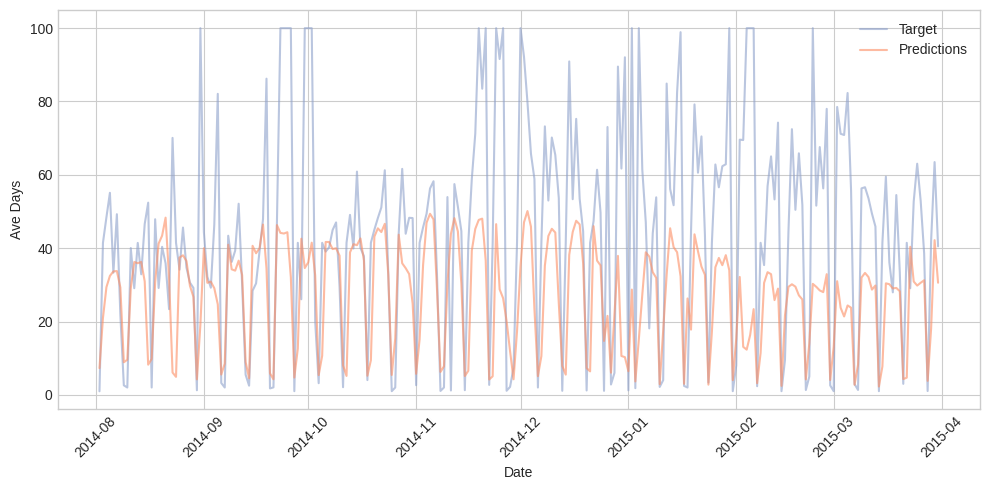

In [ ]:
# Set color palette
palette = sns.color_palette("Set2")

# Convert y_test and predictions to Series for plotting
y_test_series = pd.Series(np.exp(y_test['ave_days'].values) - 1, index=y_test.index)
predictions_series = pd.Series(np.exp(predictions) - 1, index=y_test.index)

plt.figure(figsize=(10, 5))

# Plot actual values
plt.plot(y_test_series.index, y_test_series, label='Target', color=palette[2], alpha=0.6)

# Plot predictions
plt.plot(predictions_series.index, predictions_series, label='Predictions', color=palette[1], alpha=0.6)

plt.xlabel('Date')
plt.ylabel('Ave Days')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### SVR

In [ ]:
'''# Define the parameter grid for Grid Search
param_grid_svr = {
    'C': [1, 10, 100],              # Regularization parameter
    'epsilon': [0.1, 0.2, 0.3],     # Epsilon in the epsilon-SVR model
    'kernel': ['linear', 'poly', 'rbf']  # Kernel type ('linear', 'poly', 'rbf')
}

# Initialize variables to keep track of the best MAE and corresponding parameters
best_mae_svr = float('inf')
best_params_svr = None

# Calculate total number of combinations
total_combinations_svr = len(param_grid_svr['C']) * len(param_grid_svr['epsilon']) * len(param_grid_svr['kernel'])

# Loop over all combinations of parameters with tqdm for progress tracking
for params in tqdm(list(product(*param_grid_svr.values())), total=total_combinations_svr, desc="Grid Search Progress for SVR"):
    # Create SVR model with current parameters
    svr_model = SVR(C=params[0], epsilon=params[1], kernel=params[2])

    # Train the model
    svr_model.fit(x_train, y_train)

    # Make predictions on the test set
    predictions_svr = svr_model.predict(x_test)

    # Calculate MAE
    mae_svr = mean_absolute_error((np.exp(predictions_svr) - 1), (np.exp(y_test) - 1))  # Adjust if needed

    # Check if current MAE is better than the best found so far
    if mae_svr < best_mae_svr:
        best_mae_svr = mae_svr
        best_params_svr = params

# Print the best parameters and corresponding MAE
print("Best Parameters Found for SVR:")
print("C:", best_params_svr[0])
print("epsilon:", best_params_svr[1])
print("kernel:", best_params_svr[2])
print("Lowest MAE Found:", best_mae_svr)'''

Grid Search Progress for SVR: 100%|██████████| 27/27 [07:42<00:00, 17.13s/it]

Best Parameters Found for SVR:
C: 100
epsilon: 0.1
kernel: linear
Lowest MAE Found: 22.85431264662071


In [ ]:
# Create an SVR (Support Vector Regressor) model with specified hyperparameters
svr_model = SVR(C=100, epsilon=0.1, kernel='linear')

# Fit the SVR model to the training data
svr_model.fit(x_train, y_train)

# Use the SVR model to make predictions on the test data
predictions = svr_model.predict(x_test)

# Calculate the Mean Absolute Error (MAE)
mae_value = mean_absolute_error((np.exp(predictions) - 1), (np.exp(y_test) - 1))  # Calculate MAE in original scale if necessary
print("MAE on the test set:", mae_value)

MAE on the test set: 22.85431264662071


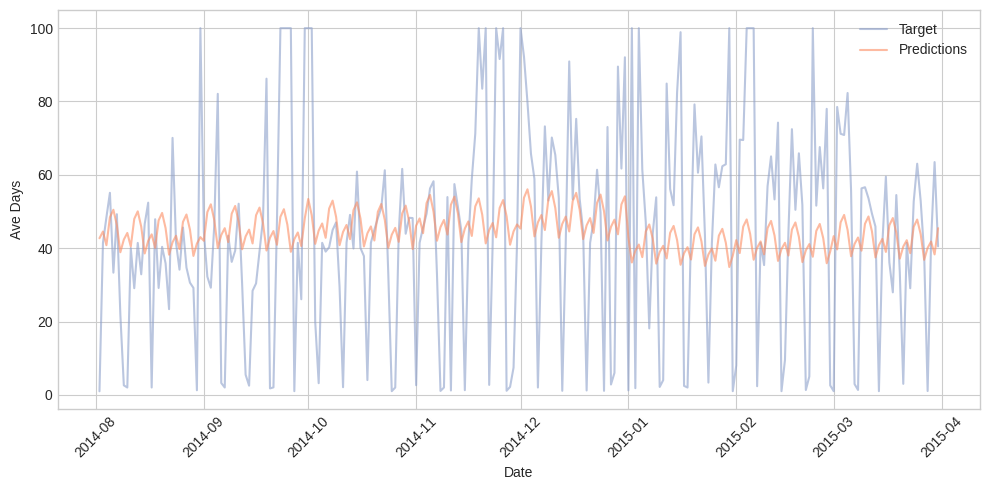

In [ ]:
# Set color palette
palette = sns.color_palette("Set2")

# Convert y_test and predictions to Series for plotting
y_test_series = pd.Series(np.exp(y_test['ave_days'].values) - 1, index=y_test.index)
predictions_series = pd.Series(np.exp(predictions) - 1, index=y_test.index)

plt.figure(figsize=(10, 5))

# Plot actual values
plt.plot(y_test_series.index, y_test_series, label='Target', color=palette[2], alpha=0.6)

# Plot predictions
plt.plot(predictions_series.index, predictions_series, label='Predictions', color=palette[1], alpha=0.6)

plt.xlabel('Date')
plt.ylabel('Ave Days')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Dataset 2

In [ ]:
# Definition of Italian holidays dates
italian_holidays = [
    (1, 1),    # New Year's Day
    (6, 1),    # Epiphany
    (25, 4),   # Liberation Day
    (1, 5),    # Labour Day
    (2, 6),    # Republic Day
    (15, 8),   # Mid-August
    (1, 11),   # All Saints' Day
    (8, 12),   # Immaculate Conception
    (25, 12),  # Christmas Day
    (26, 12)   # St. Stephen's Day
]

# Adding 'Holidays' column to the dataframe
df['holidays'] = 0

# Function to check if a date is a holiday
def is_holiday(row):
    return 1 if (row['day'], row['month']) in italian_holidays or row['weekday'] == 6 else 0

# Applying the function
df['holidays'] = df.apply(is_holiday, axis=1)

print(df)

            weekday  ave_days  year  month  day  holidays
date                                                     
2007-01-04        4  0.165080  2007      1    4         0
2007-01-05        0  0.405465  2007      1    5         0
2007-01-06        2  2.832409  2007      1    6         1
2007-01-07        3  3.748539  2007      1    7         0
2007-01-08        1  1.508897  2007      1    8         0
...             ...       ...   ...    ...  ...       ...
2015-03-27        0  3.678343  2015      3   27         0
2015-03-28        2  0.712950  2015      3   28         0
2015-03-29        3  3.761200  2015      3   29         0
2015-03-30        1  4.166310  2015      3   30         0
2015-03-31        5  3.725614  2015      3   31         0

[3009 rows x 6 columns]


In [ ]:
train = df.loc[ "2007-01-04": "2014-08-01"]
validation = df.loc["2014-08-02" : ]

#defining input and target variable
x_train = train.loc["2007-01-04": "2014-08-01",["weekday", "year", "month", "day", "holidays"]]

y_train = train.loc["2007-01-04": "2014-08-01", ['ave_days']]

x_test = validation.loc["2014-08-02" : '2015-03-31',["weekday", "year", "month", "day", "holidays"]]

y_test = validation.loc["2014-08-02" : '2015-03-31',['ave_days']]

#### XGBRegressor

In [ ]:
'''# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 3, 5, 7],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0.1, 0.2],
    'colsample_bytree': [0.5, 0.7, 0.8],
    'n_estimators': [100, 200, 500],
    'objective': ['reg:squarederror']
}

# Initialize variables to keep track of the best MAE and corresponding parameters
best_mae = float('inf')
best_params = None

# Calculate total number of combinations
total_combinations = len(param_grid['learning_rate']) * len(param_grid['max_depth']) * \
                      len(param_grid['min_child_weight']) * len(param_grid['gamma']) * \
                      len(param_grid['colsample_bytree']) * len(param_grid['n_estimators'])

# Loop over all combinations of parameters with tqdm for progress tracking
for params in tqdm(list(product(*param_grid.values())), total=total_combinations, desc="Grid Search Progress"):
    # Create XGBoost model with current parameters
    xgb_model = XGBRegressor(booster='gbtree',
                             learning_rate=params[0],
                             max_depth=params[1],
                             min_child_weight=params[2],
                             gamma=params[3],
                             colsample_bytree=params[4],
                             n_estimators=params[5],
                             objective='reg:squarederror')

    # Train the model
    xgb_model.fit(x_train, y_train)

    # Make predictions on the test set
    predictions = xgb_model.predict(x_test)

    # Calculate MAE
    mae = mean_absolute_error((np.exp(predictions) - 1), (np.exp(y_test) - 1))

    # Check if current MAE is better than the best found so far
    if mae < best_mae:
        best_mae = mae
        best_params = params

# Print the best parameters and corresponding MAE
print("Best Parameters Found:")
print("learning_rate:", best_params[0])
print("max_depth:", best_params[1])
print("min_child_weight:", best_params[2])
print("gamma:", best_params[3])
print("colsample_bytree:", best_params[4])
print("n_estimators:", best_params[5])
print("Lowest MAE Found:", best_mae)'''

Grid Search Progress: 100%|██████████| 864/864 [01:34<00:00,  9.17it/s]

Best Parameters Found:
learning_rate: 0.1
max_depth: 7
min_child_weight: 5
gamma: 0.1
colsample_bytree: 0.8
n_estimators: 100
Lowest MAE Found: 21.801718383678484


In [ ]:
# Create an XGBoost model with specific hyperparameters
xgb_model = XGBRegressor(booster='gbtree',             # Booster type: gradient boosted trees
                          colsample_bytree=0.8,        # Subsample ratio of columns when constructing each tree
                          learning_rate=0.1,           # Learning rate
                          max_depth=7,                 # Maximum depth of trees
                          min_child_weight=5,          # Minimum sum of instance weight needed in a child
                          n_estimators=100,            # Number of boosted trees (estimators)
                          gamma=0.1,                   # Minimum loss reduction required to make a further partition on a leaf node
                          objective='reg:squarederror' # Objective function: regression with squared error
                          )

# Train the XGBoost model on the training data
xgb_model.fit(x_train, y_train)

# Make predictions on the test set
predictions = xgb_model.predict(x_test)

# Calculate and print the Mean Absolute Error (MAE)
mae_value = mean_absolute_error((np.exp(predictions) - 1), (np.exp(y_test) - 1))  # Calculate MAE in original scale if necessary
print("MAE value is:", mae_value)

MAE value is: 21.801718383678484


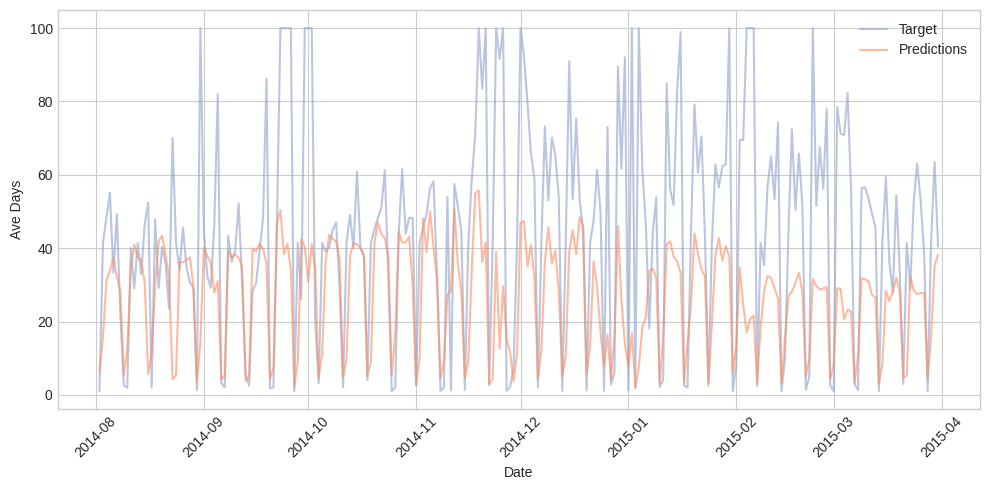

In [ ]:
# Set color palette
palette = sns.color_palette("Set2")

# Convert y_test and predictions to Series for plotting
y_test_series = pd.Series(np.exp(y_test['ave_days'].values) - 1, index=y_test.index)
predictions_series = pd.Series(np.exp(predictions) - 1, index=y_test.index)

plt.figure(figsize=(10, 5))

# Plot actual values
plt.plot(y_test_series.index, y_test_series, label='Target', color=palette[2], alpha=0.6)

# Plot predictions
plt.plot(predictions_series.index, predictions_series, label='Predictions', color=palette[1], alpha=0.6)

plt.xlabel('Date')
plt.ylabel('Ave Days')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Random Forest

In [ ]:
'''# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 30, 50, 70, 90, 110],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

# Initialize variables to keep track of the best MAE and corresponding parameters
best_mae_rf = float('inf')
best_params_rf = None

# Calculate total number of combinations
total_combinations_rf = len(param_grid_rf['n_estimators']) * len(param_grid_rf['max_depth']) * \
                         len(param_grid_rf['min_samples_split']) * len(param_grid_rf['min_samples_leaf'])

# Loop over all combinations of parameters with tqdm for progress tracking
for params in tqdm(list(product(*param_grid_rf.values())), total=total_combinations_rf, desc="Grid Search Progress for RF"):
    # Create RandomForestRegressor model with current parameters
    rf_model = RandomForestRegressor(
        n_estimators=params[0],
        max_depth=params[1],
        min_samples_split=params[2],
        min_samples_leaf=params[3],
        random_state=42
    )

    # Train the model
    rf_model.fit(x_train, y_train)

    # Make predictions on the test set
    predictions_rf = rf_model.predict(x_test)

    # Calculate MAE
    mae_rf = mean_absolute_error((np.exp(predictions_rf) - 1), (np.exp(y_test) - 1))

    # Check if current MAE is better than the best found so far
    if mae_rf < best_mae_rf:
        best_mae_rf = mae_rf
        best_params_rf = params

# Print the best parameters and corresponding MAE
print("Best Parameters Found for RandomForestRegressor:")
print("n_estimators:", best_params_rf[0])
print("max_depth:", best_params_rf[1])
print("min_samples_split:", best_params_rf[2])
print("min_samples_leaf:", best_params_rf[3])
print("Lowest MAE Found:", best_mae_rf)'''

Grid Search Progress for RF: 100%|██████████| 450/450 [09:52<00:00,  1.32s/it]

Best Parameters Found for RandomForestRegressor:
n_estimators: 400
max_depth: 10
min_samples_split: 2
min_samples_leaf: 2
Lowest MAE Found: 21.936445639921693


In [ ]:
# Create a RandomForestRegressor model with the best found hyperparameters
rf_best = RandomForestRegressor(
    n_estimators=400,          # Number of trees in the forest
    max_depth=10,              # Maximum depth of the trees
    min_samples_split=2,       # Minimum number of samples required to split an internal node
    min_samples_leaf=2,        # Minimum number of samples required to be at a leaf node
    random_state=42
)

# Train the model with the training data
rf_best.fit(x_train, y_train)

# Make predictions on the test data
predictions = rf_best.predict(x_test)

# Calculate and print the Mean Absolute Error (MAE)
mae_value = mean_absolute_error((np.exp(predictions) - 1), (np.exp(y_test) - 1))  # Calculate MAE in original scale if necessary
print("MAE value is:", mae_value)

MAE value is: 21.936445639921693


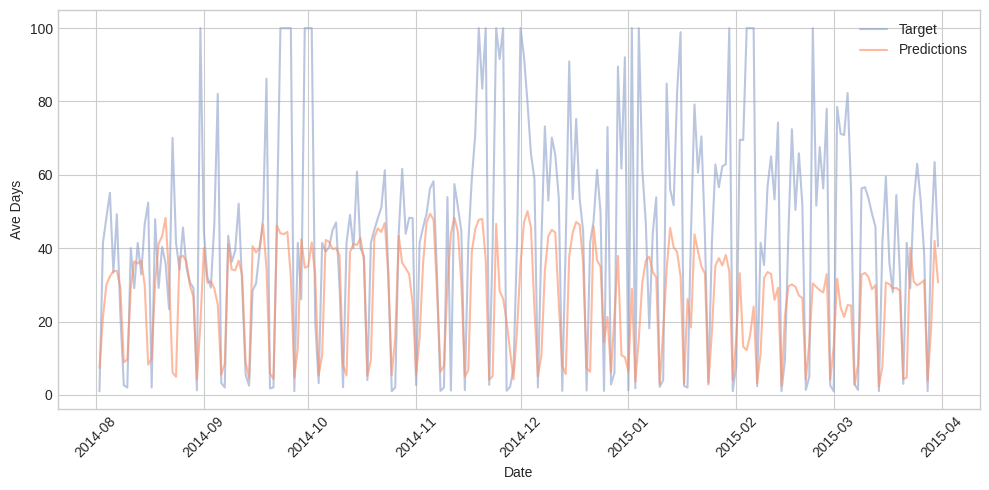

In [ ]:
# Set color palette
palette = sns.color_palette("Set2")

# Convert y_test and predictions to Series for plotting
y_test_series = pd.Series(np.exp(y_test['ave_days'].values) - 1, index=y_test.index)
predictions_series = pd.Series(np.exp(predictions) - 1, index=y_test.index)

plt.figure(figsize=(10, 5))

# Plot actual values
plt.plot(y_test_series.index, y_test_series, label='Target', color=palette[2], alpha=0.6)

# Plot predictions
plt.plot(predictions_series.index, predictions_series, label='Predictions', color=palette[1], alpha=0.6)

plt.xlabel('Date')
plt.ylabel('Ave Days')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### SVR

In [ ]:
'''# Define the parameter grid for Grid Search
param_grid_svr = {
    'C': [1, 10, 100],              # Regularization parameter
    'epsilon': [0.1, 0.2, 0.3],     # Epsilon in the epsilon-SVR model
    'kernel': ['linear', 'poly', 'rbf']  # Kernel type ('linear', 'poly', 'rbf')
}

# Initialize variables to keep track of the best MAE and corresponding parameters
best_mae_svr = float('inf')
best_params_svr = None

# Calculate total number of combinations
total_combinations_svr = len(param_grid_svr['C']) * len(param_grid_svr['epsilon']) * len(param_grid_svr['kernel'])

# Loop over all combinations of parameters with tqdm for progress tracking
for params in tqdm(list(product(*param_grid_svr.values())), total=total_combinations_svr, desc="Grid Search Progress for SVR"):
    # Create SVR model with current parameters
    svr_model = SVR(C=params[0], epsilon=params[1], kernel=params[2])

    # Train the model
    svr_model.fit(x_train, y_train)

    # Make predictions on the test set
    predictions_svr = svr_model.predict(x_test)

    # Calculate MAE
    mae_svr = mean_absolute_error((np.exp(predictions_svr) - 1), (np.exp(y_test) - 1))  # Adjust if needed

    # Check if current MAE is better than the best found so far
    if mae_svr < best_mae_svr:
        best_mae_svr = mae_svr
        best_params_svr = params

# Print the best parameters and corresponding MAE
print("Best Parameters Found for SVR:")
print("C:", best_params_svr[0])
print("epsilon:", best_params_svr[1])
print("kernel:", best_params_svr[2])
print("Lowest MAE Found:", best_mae_svr)'''

Grid Search Progress for SVR: 100%|██████████| 27/27 [08:25<00:00, 18.70s/it]

Best Parameters Found for SVR:
C: 1
epsilon: 0.2
kernel: linear
Lowest MAE Found: 22.74119200041726


In [ ]:
# Create an SVR (Support Vector Regressor) model with specified hyperparameters
svr_model = SVR(C=1, epsilon=0.2, kernel='linear')

# Fit the SVR model to the training data
svr_model.fit(x_train, y_train)

# Use the SVR model to make predictions on the test data
predictions = svr_model.predict(x_test)

# Calculate the Mean Absolute Error (MAE)
mae_value = mean_absolute_error((np.exp(predictions) - 1), (np.exp(y_test) - 1))  # Calculate MAE in original scale if necessary
print("MAE on the test set:", mae_value)

MAE on the test set: 22.74119200041726


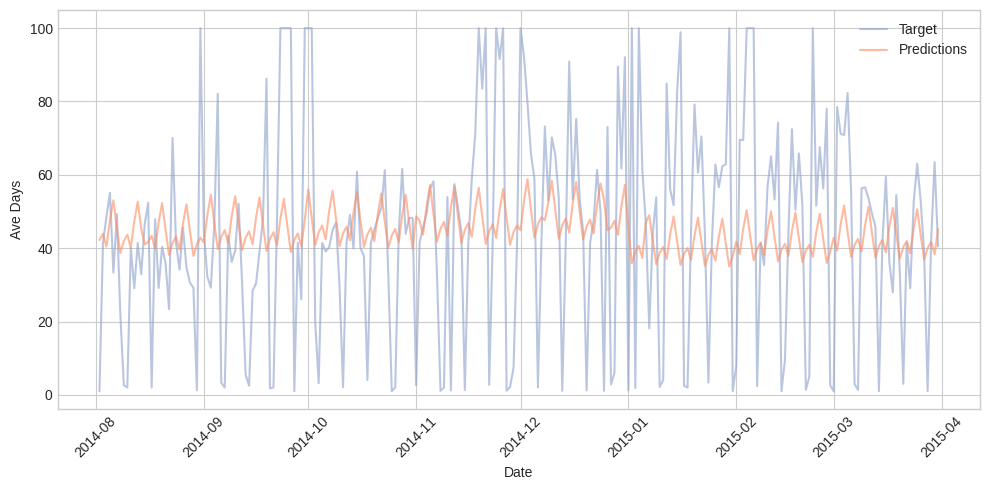

In [ ]:
# Set color palette
palette = sns.color_palette("Set2")

# Convert y_test and predictions to Series for plotting
y_test_series = pd.Series(np.exp(y_test['ave_days'].values) - 1, index=y_test.index)
predictions_series = pd.Series(np.exp(predictions) - 1, index=y_test.index)

plt.figure(figsize=(10, 5))

# Plot actual values
plt.plot(y_test_series.index, y_test_series, label='Target', color=palette[2], alpha=0.6)

# Plot predictions
plt.plot(predictions_series.index, predictions_series, label='Predictions', color=palette[1], alpha=0.6)

plt.xlabel('Date')
plt.ylabel('Ave Days')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Dataset 3

In [ ]:
# Definition of Italian holidays dates with their names
italian_holidays = {
    'new_year': (1, 1),
    'epiphany': (6, 1),
    'liberation_day': (25, 4),
    'labour_day': (1, 5),
    'republic_day': (2, 6),
    'mid-August': (15, 8),
    'all_saints_day': (1, 11),
    'immaculate': (8, 12),
    'christmas_day': (25, 12),
    'st_stephens_day': (26, 12)
}
# Adding columns for each holiday, initialized to 0
for holiday in italian_holidays.keys():
    df[holiday] = 0

# Function to mark holidays in the respective columns
def mark_holidays(row):
    for holiday, (day, month) in italian_holidays.items():
        if row['day'] == day and row['month'] == month:
            row[holiday] = 1
    return row

# Applying the function to each row in the DataFrame
df = df.apply(mark_holidays, axis=1)

# Marking Sundays
df['sunday'] = df['weekday'].apply(lambda x: 1 if x == 6 else 0)

# Ensure holiday columns are binary (0 or 1)
for holiday in italian_holidays.keys():
    df[holiday] = df[holiday].astype(int)

# Convert day, month, weekday, and year columns back to integers
df[['day', 'month', 'weekday', 'year']] = df[['day', 'month', 'weekday', 'year']].astype(int)

print(df)

            weekday  ave_days  year  month  day  new_year  epiphany  \
date                                                                  
2007-01-04        4  0.165080  2007      1    4         0         0   
2007-01-05        0  0.405465  2007      1    5         0         0   
2007-01-06        2  2.832409  2007      1    6         0         1   
2007-01-07        3  3.748539  2007      1    7         0         0   
2007-01-08        1  1.508897  2007      1    8         0         0   
...             ...       ...   ...    ...  ...       ...       ...   
2015-03-27        0  3.678343  2015      3   27         0         0   
2015-03-28        2  0.712950  2015      3   28         0         0   
2015-03-29        3  3.761200  2015      3   29         0         0   
2015-03-30        1  4.166310  2015      3   30         0         0   
2015-03-31        5  3.725614  2015      3   31         0         0   

            liberation_day  labour_day  republic_day  mid-August  \
date    

In [ ]:
train = df.loc[ "2007-01-04": "2014-08-01"]
validation = df.loc["2014-08-02" : ]

#defining input and target variable
x_train = train.loc["2007-01-04": "2014-08-01",["weekday", "year", "month", "day", "new_year", "epiphany", "liberation_day", "labour_day",
                                                "republic_day", "mid-August", "all_saints_day", "immaculate", "christmas_day", "st_stephens_day", "sunday"]]

y_train = train.loc["2007-01-04": "2014-08-01", ['ave_days']]

x_test = validation.loc["2014-08-02" : '2015-03-31',["weekday", "year", "month", "day", "new_year", "epiphany", "liberation_day", "labour_day",
                                                     "republic_day", "mid-August", "all_saints_day", "immaculate", "christmas_day", "st_stephens_day", "sunday"]]

y_test = validation.loc["2014-08-02" : '2015-03-31',['ave_days']]

#### XGBRegressor

In [ ]:
'''# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 3, 5, 7],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0.1, 0.2],
    'colsample_bytree': [0.5, 0.7, 0.8],
    'n_estimators': [100, 200, 500],
    'objective': ['reg:squarederror']
}

# Initialize variables to keep track of the best MAE and corresponding parameters
best_mae = float('inf')
best_params = None

# Calculate total number of combinations
total_combinations = len(param_grid['learning_rate']) * len(param_grid['max_depth']) * \
                      len(param_grid['min_child_weight']) * len(param_grid['gamma']) * \
                      len(param_grid['colsample_bytree']) * len(param_grid['n_estimators'])

# Loop over all combinations of parameters with tqdm for progress tracking
for params in tqdm(list(product(*param_grid.values())), total=total_combinations, desc="Grid Search Progress"):
    # Create XGBoost model with current parameters
    xgb_model = XGBRegressor(booster='gbtree',
                             learning_rate=params[0],
                             max_depth=params[1],
                             min_child_weight=params[2],
                             gamma=params[3],
                             colsample_bytree=params[4],
                             n_estimators=params[5],
                             objective='reg:squarederror')

    # Train the model
    xgb_model.fit(x_train, y_train)

    # Make predictions on the test set
    predictions = xgb_model.predict(x_test)

    # Calculate MAE
    mae = mean_absolute_error((np.exp(predictions) - 1), (np.exp(y_test) - 1))

    # Check if current MAE is better than the best found so far
    if mae < best_mae:
        best_mae = mae
        best_params = params

# Print the best parameters and corresponding MAE
print("Best Parameters Found:")
print("learning_rate:", best_params[0])
print("max_depth:", best_params[1])
print("min_child_weight:", best_params[2])
print("gamma:", best_params[3])
print("colsample_bytree:", best_params[4])
print("n_estimators:", best_params[5])
print("Lowest MAE Found:", best_mae)'''

Grid Search Progress: 100%|██████████| 864/864 [02:30<00:00,  5.73it/s]

Best Parameters Found:
learning_rate: 0.01
max_depth: 7
min_child_weight: 1
gamma: 0.1
colsample_bytree: 0.8
n_estimators: 500
Lowest MAE Found: 22.125620140602635


In [ ]:
# Create an XGBoost model with specific hyperparameters
xgb_model = XGBRegressor(booster='gbtree',             # Booster type: gradient boosted trees
                          colsample_bytree=0.8,        # Subsample ratio of columns when constructing each tree
                          learning_rate=0.01,           # Learning rate
                          max_depth=7,                 # Maximum depth of trees
                          min_child_weight=1,          # Minimum sum of instance weight needed in a child
                          n_estimators=500,            # Number of boosted trees (estimators)
                          gamma=0.1,                   # Minimum loss reduction required to make a further partition on a leaf node
                          objective='reg:squarederror' # Objective function: regression with squared error
                          )

# Train the XGBoost model on the training data
xgb_model.fit(x_train, y_train)

# Make predictions on the test set
predictions = xgb_model.predict(x_test)

# Calculate and print the Mean Absolute Error (MAE)
mae_value = mean_absolute_error((np.exp(predictions) - 1), (np.exp(y_test) - 1))  # Calculate MAE in original scale if necessary

print("MAE value is:", mae_value)

MAE value is: 22.125620140602635


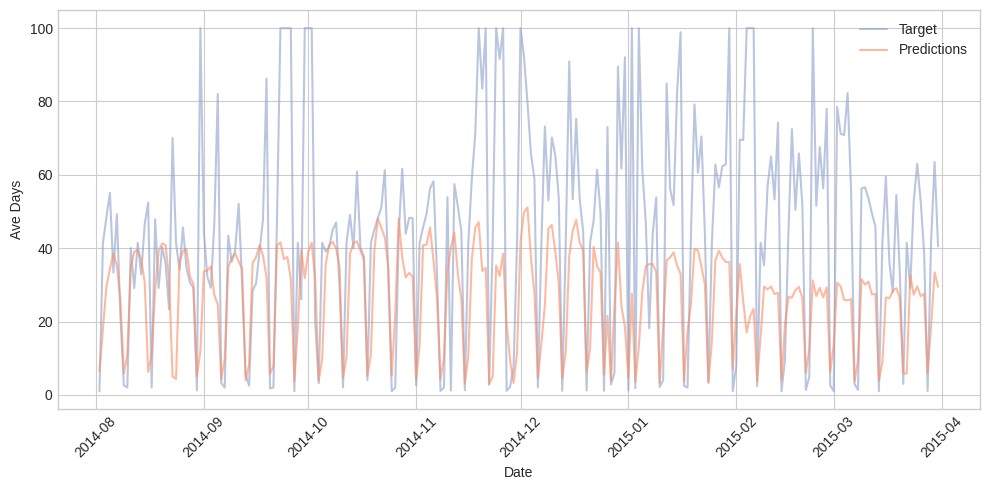

In [ ]:
# Set color palette
palette = sns.color_palette("Set2")

# Convert y_test and predictions to Series for plotting
y_test_series = pd.Series(np.exp(y_test['ave_days'].values) - 1, index=y_test.index)
predictions_series = pd.Series(np.exp(predictions) - 1, index=y_test.index)

plt.figure(figsize=(10, 5))

# Plot actual values
plt.plot(y_test_series.index, y_test_series, label='Target', color=palette[2], alpha=0.6)

# Plot predictions
plt.plot(predictions_series.index, predictions_series, label='Predictions', color=palette[1], alpha=0.6)

plt.xlabel('Date')
plt.ylabel('Ave Days')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Random Forest

In [ ]:
'''# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 30, 50, 70, 90, 110],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

# Initialize variables to keep track of the best MAE and corresponding parameters
best_mae_rf = float('inf')
best_params_rf = None

# Calculate total number of combinations
total_combinations_rf = len(param_grid_rf['n_estimators']) * len(param_grid_rf['max_depth']) * \
                         len(param_grid_rf['min_samples_split']) * len(param_grid_rf['min_samples_leaf'])

# Loop over all combinations of parameters with tqdm for progress tracking
for params in tqdm(list(product(*param_grid_rf.values())), total=total_combinations_rf, desc="Grid Search Progress for RF"):
    # Create RandomForestRegressor model with current parameters
    rf_model = RandomForestRegressor(
        n_estimators=params[0],
        max_depth=params[1],
        min_samples_split=params[2],
        min_samples_leaf=params[3],
        random_state=42
    )

    # Train the model
    rf_model.fit(x_train, y_train)

    # Make predictions on the test set
    predictions_rf = rf_model.predict(x_test)

    # Calculate MAE
    mae_rf = mean_absolute_error((np.exp(predictions_rf) - 1), (np.exp(y_test) - 1))

    # Check if current MAE is better than the best found so far
    if mae_rf < best_mae_rf:
        best_mae_rf = mae_rf
        best_params_rf = params

# Print the best parameters and corresponding MAE
print("Best Parameters Found for RandomForestRegressor:")
print("n_estimators:", best_params_rf[0])
print("max_depth:", best_params_rf[1])
print("min_samples_split:", best_params_rf[2])
print("min_samples_leaf:", best_params_rf[3])
print("Lowest MAE Found:", best_mae_rf)'''

Grid Search Progress for RF: 100%|██████████| 450/450 [11:34<00:00,  1.54s/it]

Best Parameters Found for RandomForestRegressor:
n_estimators: 300
max_depth: 10
min_samples_split: 2
min_samples_leaf: 1
Lowest MAE Found: 21.77940497029594


In [ ]:
# Create a RandomForestRegressor model with the best found hyperparameters
rf_best = RandomForestRegressor(
    n_estimators=300,          # Number of trees in the forest
    max_depth=10,              # Maximum depth of the trees
    min_samples_split=2,       # Minimum number of samples required to split an internal node
    min_samples_leaf=1,        # Minimum number of samples required to be at a leaf node
    random_state=42
)

# Train the model with the training data
rf_best.fit(x_train, y_train)

# Make predictions on the test data
predictions = rf_best.predict(x_test)

# Calculate and print the Mean Absolute Error (MAE)
mae_value = mean_absolute_error((np.exp(predictions) - 1), (np.exp(y_test) - 1))  # Calculate MAE in original scale if necessary
print("MAE value is:", mae_value)

MAE value is: 21.77940497029594


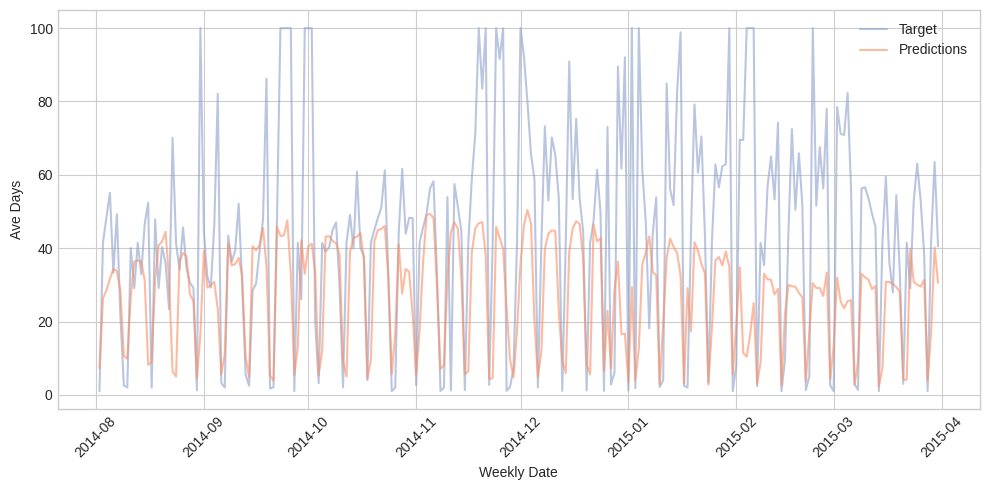

In [ ]:
# Set color palette
palette = sns.color_palette("Set2")

# Convert y_test and predictions to Series for plotting
y_test_series = pd.Series(np.exp(y_test['ave_days'].values) - 1, index=y_test.index)
predictions_series = pd.Series(np.exp(predictions) - 1, index=y_test.index)

plt.figure(figsize=(10, 5))

# Plot actual values
plt.plot(y_test_series.index, y_test_series, label='Target', color=palette[2], alpha=0.6)

# Plot predictions
plt.plot(predictions_series.index, predictions_series, label='Predictions', color=palette[1], alpha=0.6)

plt.xlabel('Weekly Date')
plt.ylabel('Ave Days')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### SVR

In [ ]:
'''# Define the parameter grid for Grid Search
param_grid_svr = {
    'C': [1, 10, 100],              # Regularization parameter
    'epsilon': [0.1, 0.2, 0.3],     # Epsilon in the epsilon-SVR model
    'kernel': ['linear', 'poly', 'rbf']  # Kernel type ('linear', 'poly', 'rbf')
}

# Initialize variables to keep track of the best MAE and corresponding parameters
best_mae_svr = float('inf')
best_params_svr = None

# Calculate total number of combinations
total_combinations_svr = len(param_grid_svr['C']) * len(param_grid_svr['epsilon']) * len(param_grid_svr['kernel'])

# Loop over all combinations of parameters with tqdm for progress tracking
for params in tqdm(list(product(*param_grid_svr.values())), total=total_combinations_svr, desc="Grid Search Progress for SVR"):
    # Create SVR model with current parameters
    svr_model = SVR(C=params[0], epsilon=params[1], kernel=params[2])

    # Train the model
    svr_model.fit(x_train, y_train)

    # Make predictions on the test set
    predictions_svr = svr_model.predict(x_test)

    # Calculate MAE
    mae_svr = mean_absolute_error((np.exp(predictions_svr) - 1), (np.exp(y_test) - 1))  # Adjust if needed

    # Check if current MAE is better than the best found so far
    if mae_svr < best_mae_svr:
        best_mae_svr = mae_svr
        best_params_svr = params

# Print the best parameters and corresponding MAE
print("Best Parameters Found for SVR:")
print("C:", best_params_svr[0])
print("epsilon:", best_params_svr[1])
print("kernel:", best_params_svr[2])
print("Lowest MAE Found:", best_mae_svr)'''

Grid Search Progress for SVR: 100%|██████████| 27/27 [09:12<00:00, 20.46s/it]

Best Parameters Found for SVR:
C: 10
epsilon: 0.1
kernel: linear
Lowest MAE Found: 22.800196826997656


In [ ]:
# Create an SVR (Support Vector Regressor) model with specified hyperparameters
svr_model = SVR(C=10, epsilon=0.1, kernel='linear')

# Fit the SVR model to the training data
svr_model.fit(x_train, y_train)

# Use the SVR model to make predictions on the test data
predictions = svr_model.predict(x_test)

# Calculate the Mean Absolute Error (MAE)
mae_value = mean_absolute_error((np.exp(predictions) - 1), (np.exp(y_test) - 1))  # Calculate MAE in original scale if necessary
print("MAE on the test set:", mae_value)

MAE on the test set: 22.800196826997656


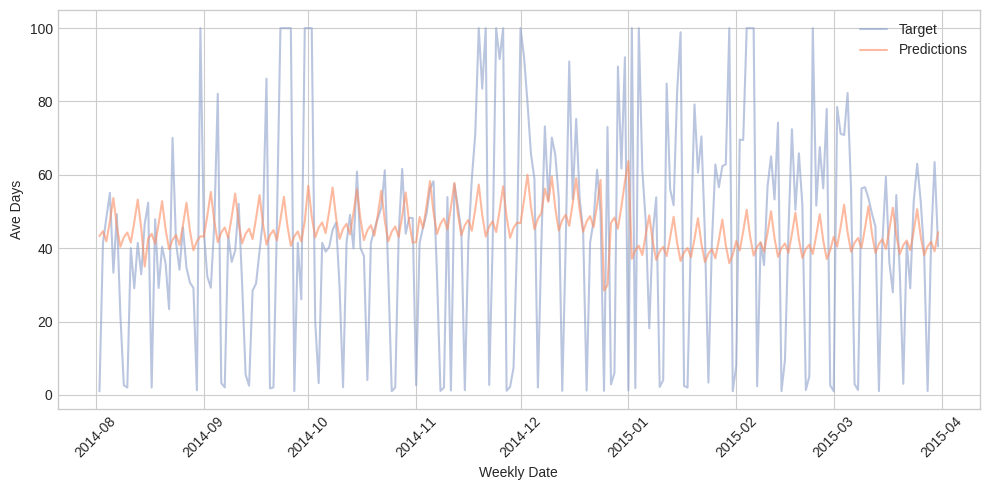

In [ ]:
# Set color palette
palette = sns.color_palette("Set2")

# Convert y_test and predictions to Series for plotting
y_test_series = pd.Series(np.exp(y_test['ave_days'].values) - 1, index=y_test.index)
predictions_series = pd.Series(np.exp(predictions) - 1, index=y_test.index)

plt.figure(figsize=(10, 5))

# Plot actual values
plt.plot(y_test_series.index, y_test_series, label='Target', color=palette[2], alpha=0.6)

# Plot predictions
plt.plot(predictions_series.index, predictions_series, label='Predictions', color=palette[1], alpha=0.6)

plt.xlabel('Weekly Date')
plt.ylabel('Ave Days')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Forecast

In [ ]:
# Define the period for forecasting
forecast_start = "2015-04-01"
forecast_end = "2015-11-07"

# Create a DataFrame with the dates for forecasting
forecast= pd.date_range(start=forecast_start, end=forecast_end, freq='D')
forecast_df = pd.DataFrame(index=forecast, columns=["weekday", "year", "month", "day", "new_year", "epiphany", "liberation_day", "labour_day",
                                                            "republic_day", "mid-August", "all_saints_day", "immaculate", "christmas_day", "st_stephens_day", "sunday"])
# Extract year, month, and day
forecast_df["weekday"] = forecast_df.index.weekday
forecast_df['year'] = forecast_df.index.year
forecast_df['month'] = forecast_df.index.month
forecast_df['day'] = forecast_df.index.day


# Fill in sunday column (1 if Sunday, else 0)
forecast_df["sunday"] = np.where(forecast_df.index.weekday == 6, 1, 0)

# Define holidays
holidays = {
    "new_year": "01-01",
    "epiphany": "01-06",
    "liberation_day": "04-25",
    "labour_day": "05-01",
    "republic_day": "06-02",
    "mid-August": "08-15",
    "all_saints_day": "11-01",
    "immaculate": "12-08",
    "christmas_day": "12-25",
    "st_stephens_day": "12-26"
}

# Fill in holiday columns (1 if holiday, else 0)
for holiday, date_str in holidays.items():
    forecast_df[holiday] = np.where((forecast_df.index.month == int(date_str[:2])) &
                                    (forecast_df.index.day == int(date_str[3:])), 1, 0)

# Display the resulting DataFrame
print(forecast_df.head())

            weekday  year  month  day  new_year  epiphany  liberation_day  \
2015-04-01        2  2015      4    1         0         0               0   
2015-04-02        3  2015      4    2         0         0               0   
2015-04-03        4  2015      4    3         0         0               0   
2015-04-04        5  2015      4    4         0         0               0   
2015-04-05        6  2015      4    5         0         0               0   

            labour_day  republic_day  mid-August  all_saints_day  immaculate  \
2015-04-01           0             0           0               0           0   
2015-04-02           0             0           0               0           0   
2015-04-03           0             0           0               0           0   
2015-04-04           0             0           0               0           0   
2015-04-05           0             0           0               0           0   

            christmas_day  st_stephens_day  sunday  
201

In [ ]:
# Make predictions for the forecast period
forecast_predictions = rf_best.predict(forecast_df)

# Create a DataFrame to store the forecast results
forecast_results_rf = pd.DataFrame(index=forecast)
forecast_results_rf['RF'] = np.exp(forecast_predictions) - 1

# Print or use the forecast_results DataFrame as needed
print(forecast_results_rf)

                   RF
2015-04-01   3.389041
2015-04-02  10.643810
2015-04-03  31.782433
2015-04-04  28.555509
2015-04-05  32.088355
...               ...
2015-11-03  36.169333
2015-11-04   5.573792
2015-11-05  12.943815
2015-11-06  48.253079
2015-11-07  47.586444

[221 rows x 1 columns]


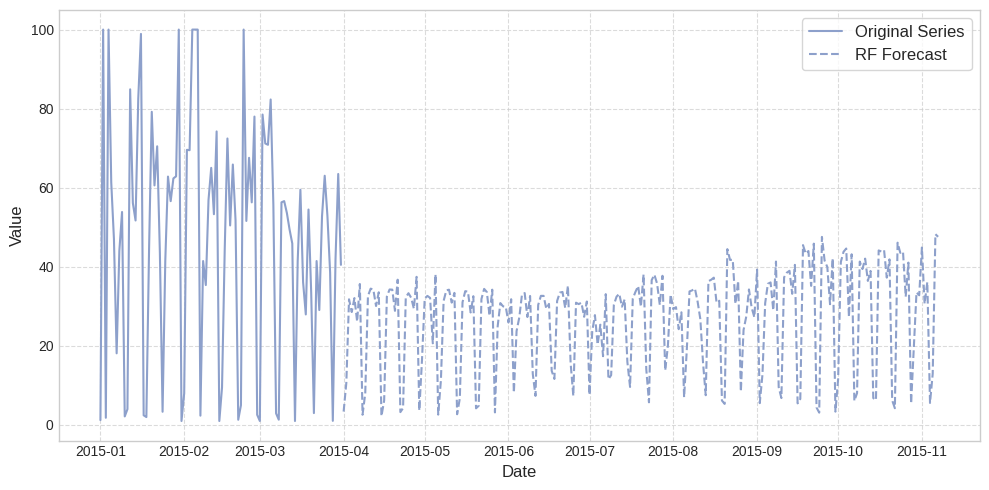

In [ ]:
# Extract the last 3 months of the original series
last_3_months_values = np.exp(df[["ave_days"]].tail(90)) - 1 # Values of the last 90 days

# Create a combined dataframe
combined_df = pd.concat([last_3_months_values, forecast_results_rf], axis=1)
combined_df.columns = ['Original Series', 'RF Forecast']  # Rename columns for clarity

# Set color palette for visual consistency
palette = sns.color_palette("Set2")

# Set plot style for better readability
plt.style.use('seaborn-whitegrid')

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(combined_df.index, combined_df['Original Series'], label='Original Series', color=palette[2])
plt.plot(combined_df.index, combined_df['RF Forecast'], label='RF Forecast', color=palette[2], linestyle='dashed')

# Set labels for x and y axes
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Add a legend with frame for clarity
plt.legend(fontsize=12, loc='best', frameon=True)

# Add a light grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

# Aggregation

In [ ]:
# Merge the DataFrames by index
merged_df = forecast_df_sarima.join([forecast_df_ucm, forecast_results_rf])

# Save the resulting DataFrame to a CSV file
merged_df.to_csv('/content/drive/MyDrive/Time Series Analysis/853189_20240705.csv', index=True)

In [ ]:
merged_df

,SARIMA,UCM,RF
2015-04-01,51.687207,44.982046,3.389041
2015-04-02,42.750578,41.470490,10.643810
2015-04-03,42.343617,34.361749,31.782433
2015-04-04,2.184731,7.306288,28.555509
2015-04-05,16.432045,19.324976,32.088355
...,...,...,...
2015-11-03,40.833627,42.491370,36.169333
2015-11-04,43.590629,44.275898,5.573792
2015-11-05,35.885376,40.818270,12.943815
2015-11-06,37.738163,33.818697,48.253079


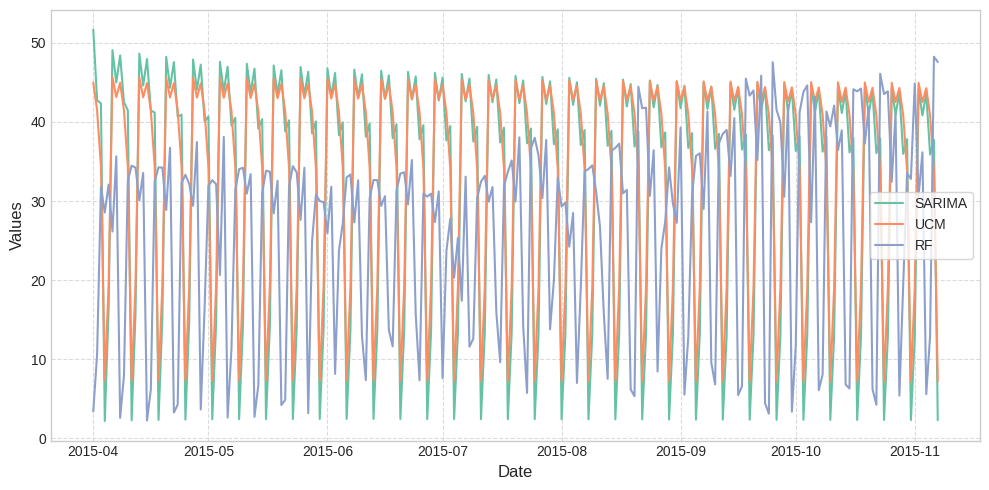

In [ ]:
# Set the style of the plot
plt.style.use('seaborn-whitegrid')

# Color palette for visual consistency
palette = sns.color_palette("Set2")

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(merged_df.index, merged_df['SARIMA'], label='SARIMA', color=palette[0])
plt.plot(merged_df.index, merged_df['UCM'], label='UCM', color=palette[1])
plt.plot(merged_df.index, merged_df['RF'], label='RF', color=palette[2])

# Set axis labels
plt.xlabel('Date', fontsize=12)
plt.ylabel('Values', fontsize=12)

# Add a legend with reduced text size
plt.legend(fontsize=10, loc='best', frameon=True)

# Add a light grid
plt.grid(True, linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()